In [1]:
import os

import xarray as xr
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import configparser

from modules.modules_FIG_08_10_11 import *

config = configparser.ConfigParser()
config.read("ConfigFile.ini")
pf = config['PATHS']['datasets']

ECRAD = xr.open_dataset(os.path.join(pf,"TCARS.nc"))

## Values of RMSE and MBE from CAMS RA vs AERONET comparison
# AOD,AE,SSA,G
RMSE = np.array([0.09,0.36,0.07,0.04])
MBE = np.array([-0.001,-0.12,-0.03,-0.001])

---
# Fig 15 and FIG A1
These figures show the annual and spatial mean of daily REari over Germany. The REari kernels are used and scaled by RMSE for AOD,AE,SSA and G to estimate a daily uncertainty of REari with CAMSRA as input. 

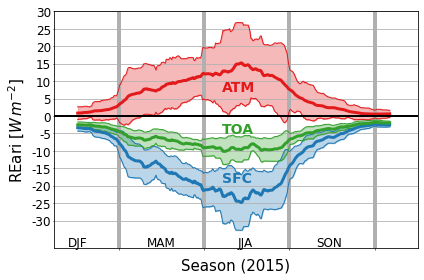

In [2]:
# FIG15

COLORS = dict(sfc='#1f78b4',
              toa ='#33a02c',
              atm = '#e31a1c')


Eyear = ECRAD.median(dim=['lat','lon'],skipna=True)


pData = np.vstack([Eyear.AOD.values,
                   Eyear.AE.values,
                   Eyear.SSA.values,
                   Eyear.G.values])



# calcualte fraction in %
pRMSE=100.*RMSE[:,np.newaxis] / pData


# annual mean of relative kernel
Ksfc = np.vstack([Eyear.median(dim='day').kernel_AOD_sfc.values,
                  Eyear.median(dim='day').kernel_AE_sfc.values,
                  Eyear.median(dim='day').kernel_SSA_sfc.values,
                  Eyear.median(dim='day').kernel_G_sfc.values])
Ktoa = np.vstack([Eyear.median(dim='day').kernel_AOD_toa.values,
                  Eyear.median(dim='day').kernel_AE_toa.values,
                  Eyear.median(dim='day').kernel_SSA_toa.values,
                  Eyear.median(dim='day').kernel_G_toa.values])

RMSEsfc = np.sqrt(np.sum((Ksfc*pRMSE)**2,axis=0))
RMSEtoa = np.sqrt(np.sum((Ktoa*pRMSE)**2,axis=0))

Eyear = Eyear.assign(dict(RMSE_sfc = ('day',RMSEsfc),
                          RMSE_toa = ('day',RMSEtoa)))


RMSEsfc = Eyear.RMSE_sfc.rolling(day=30,center=True).mean().values
RMSEtoa = Eyear.RMSE_sfc.rolling(day=30,center=True).mean().values
RMSEatm = np.sqrt(RMSEtoa**2+RMSEsfc**2)
RF_sfc = Eyear.REari_sfc.rolling(day=30,center=True).mean().values
RF_toa = Eyear.REari_toa.rolling(day=30,center=True).mean().values
RF_atm = (Eyear.REari_toa-Eyear.REari_sfc).rolling(day=30,center=True).mean().values
# RF_atm = RF_toa-RF_sfc

RFstd_sfc = Eyear.REari_sfc.rolling(day=30,center=True).std().values
RFstd_toa = Eyear.REari_toa.rolling(day=30,center=True).std().values
RFstd_atm = (Eyear.REari_toa-Eyear.REari_sfc).rolling(day=30,center=True).std().values
RFstd_atm = RFstd_toa + RFstd_sfc



fig = plt.figure()
ax = fig.add_subplot(111)

# ax.fill_between(np.arange(len(ECRAD.day)),RF_sfc-RMSEsfc,RF_sfc+RMSEsfc,color=COLORS['sfc'],alpha=0.3)
# ax.fill_between(np.arange(len(ECRAD.day)),RF_toa-RMSEtoa,RF_toa+RMSEtoa,color=COLORS['toa'],alpha=0.3)
# ax.fill_between(np.arange(len(ECRAD.day)),RF_atm-RMSEatm,RF_atm+RMSEatm,color=COLORS['atm'],alpha=0.3)
ax.fill_between(np.arange(len(ECRAD.day)),RF_sfc-RFstd_sfc,RF_sfc+RFstd_sfc,color=COLORS['sfc'],alpha=0.3)
ax.fill_between(np.arange(len(ECRAD.day)),RF_toa-RFstd_toa,RF_toa+RFstd_toa,color=COLORS['toa'],alpha=0.3)
ax.fill_between(np.arange(len(ECRAD.day)),RF_atm-RFstd_atm,RF_atm+RFstd_atm,color=COLORS['atm'],alpha=0.3)

# ax.plot(RF_sfc+RMSEsfc,color=COLORS['sfc'],linewidth=1)
# ax.plot(RF_toa+RMSEtoa,color=COLORS['toa'],linewidth=1)
# ax.plot(RF_atm+RMSEatm,color=COLORS['atm'],linewidth=1)
# ax.plot(RF_sfc-RMSEsfc,color=COLORS['sfc'],linewidth=1)
# ax.plot(RF_toa-RMSEtoa,color=COLORS['toa'],linewidth=1)
# ax.plot(RF_atm-RMSEatm,color=COLORS['atm'],linewidth=1)
ax.plot(RF_sfc+RFstd_sfc,color=COLORS['sfc'],linewidth=1)
ax.plot(RF_toa+RFstd_toa,color=COLORS['toa'],linewidth=1)
ax.plot(RF_atm+RFstd_atm,color=COLORS['atm'],linewidth=1)
ax.plot(RF_sfc-RFstd_sfc,color=COLORS['sfc'],linewidth=1)
ax.plot(RF_toa-RFstd_toa,color=COLORS['toa'],linewidth=1)
ax.plot(RF_atm-RFstd_atm,color=COLORS['atm'],linewidth=1)


ax.plot(RF_sfc,color=COLORS['sfc'],linewidth=3)
ax.plot(RF_toa,color=COLORS['toa'],linewidth=3)
ax.plot(RF_atm,color=COLORS['atm'],linewidth=3)


ax.annotate("TOA",(170,-5),
            fontsize=14,
            fontweight='bold',
            color=COLORS['toa'])
ax.annotate("SFC",(170,-19),
            fontsize=14,
            fontweight='bold',
            color=COLORS['sfc'])
ax.annotate("ATM",(170,7),
            fontsize=14,
            fontweight='bold',
            color=COLORS['atm'])


## plot config
ax.axhline(0,color='k',linewidth=2)
ax.set_xlim([-10,380])
ax.set_ylim([-38,29])
# config axis labels
ax.set_xticks(np.linspace(15,285,4))
yticks = np.arange(-30,35,5)
ax.set_yticks(yticks+0.001)
ax.set_xticklabels(['DJF','MAM','JJA','SON'])#,fontweight='bold')
ax.set_yticklabels(yticks,fontsize=10)
ax.tick_params('x',color='',length=0,pad=-12,labelsize='large')
ax.tick_params('y',color='',length=0,labelsize='large',labelleft=True,labelright=False)#pad=-25
# config for gridlines
ax.set_xticks(np.linspace(59,334,4),minor=True)
ax.set_yticks(yticks,minor = True)
ax.grid(which='minor')
ax.tick_params('x',which='minor',grid_linewidth=4)
ax.tick_params('y',which='minor',color='k',length=1,pad=-20)
ax.set_xlabel('Season (2015)',fontsize=15)#,fontweight='bold')
ax.set_ylabel(r'REari $\left[W\,m^{-2}\right]$',fontsize=15)#,fontweight='bold')

plt.tight_layout()
plt.savefig("Figures/Fig15.pdf",dpi=300,bbox_inches='tight')

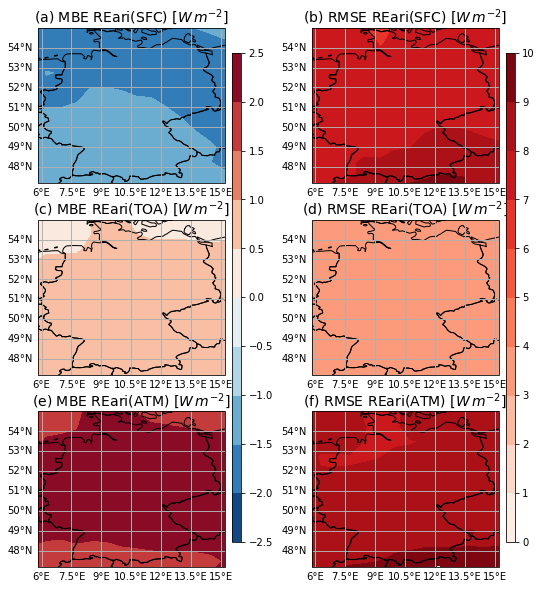

In [3]:
# FIGA1


Eyear = ECRAD.mean(dim='day',skipna=True)

pData = np.concatenate([Eyear.AOD.values[np.newaxis,:,:],
                        Eyear.AE.values[np.newaxis,:,:],
                        Eyear.SSA.values[np.newaxis,:,:],
                        Eyear.G.values[np.newaxis,:,:]],axis=0)




# calcualte fraction in %
pMBE=100.*MBE[:,np.newaxis,np.newaxis] / pData
pRMSE=100.*RMSE[:,np.newaxis,np.newaxis] / pData


# annual mean of relative kernel
Ksfc = np.concatenate([Eyear.kernel_AOD_sfc.values[np.newaxis,:,:],
                      Eyear.kernel_AE_sfc.values[np.newaxis,:,:],
                      Eyear.kernel_SSA_sfc.values[np.newaxis,:,:],
                      Eyear.kernel_G_sfc.values[np.newaxis,:,:]],axis=0)
Ktoa = np.concatenate([Eyear.kernel_AOD_toa.values[np.newaxis,:,:],
                  Eyear.kernel_AE_toa.values[np.newaxis,:,:],
                  Eyear.kernel_SSA_toa.values[np.newaxis,:,:],
                  Eyear.kernel_G_toa.values[np.newaxis,:,:]],axis=0)

MBEsfc = np.sum((Ksfc*pMBE),axis=0)
MBEtoa = np.sum((Ktoa*pMBE),axis=0)

RMSEsfc = np.sqrt(np.sum((Ksfc*pRMSE)**2,axis=0))
RMSEtoa = np.sqrt(np.sum((Ktoa*pRMSE)**2,axis=0))





cmap='RdBu_r'
cbticks1=np.arange(-2.5,3,0.5)
cbticks=np.arange(0,11,1)
# cbticks=[-5.5,-2,-1.5,-1,-0.5,0]+list(np.arange(0.5,6.5,0.5))
# cbticks=list(np.arange(-5,0.25,0.25)) + list(np.arange(0.5,6.5,0.5))
cbspacing = 'proportional'


fig = plt.figure(figsize=(9,10))
fig,ax1 = make_plot(fig,(3,2,1),Eyear.lon,Eyear.lat,MBEsfc,cmap=cmap,cbarres=2,
#                    cbticks=None,#[-1.4,-1.3,-1.2,-1.1,-1,-0.9,-0.8,-0.6,0],
                    cbticks=cbticks1,
                    cbspacing = cbspacing,
                    cb=False,
                   title=r'(a) MBE REari(SFC) [$W\,m^{-2}$]')

# fig = plt.figure(figsize=(11,8))
fig,ax2 = make_plot(fig,(3,2,3),Eyear.lon,Eyear.lat,MBEtoa,cmap=cmap,cbarres=2,
#                    cbticks=None,
                    cbticks=cbticks1,
                    cbspacing = cbspacing,
                    cb=False,
                   title=r'(c) MBE REari(TOA) [$W\,m^{-2}$]')

# fig = plt.figure(figsize=(11,8))
fig,ax3 = make_plot(fig,(3,2,5),Eyear.lon,Eyear.lat,(MBEtoa-MBEsfc),cmap=cmap,cbarres=2,
#                    cbticks=None,
                    cbaxextend=[ax1,ax2],
                    cbpanchor=(-0.1,0.5),
                    cbticks=cbticks1,
                    cbspacing = cbspacing,
                    cbaspect=50,
                   title=r'(e) MBE REari(ATM) [$W\,m^{-2}$]')

# fig = plt.figure(figsize=(11,8))
fig,ax4 = make_plot(fig,(3,2,2),Eyear.lon,Eyear.lat,RMSEsfc,cmap='Reds',cbarres=2,
#                    cbticks=None,
                    cbticks=cbticks,
                    cbspacing = cbspacing,
                   cb=False,
                   title=r'(b) RMSE REari(SFC) [$W\,m^{-2}$]')

# fig = plt.figure(figsize=(11,8))
fig,ax5 = make_plot(fig,(3,2,4),Eyear.lon,Eyear.lat,RMSEtoa,cmap='Reds',cbarres=2,
#                    cbticks=None,
                    cbticks=cbticks,
                    cbspacing = cbspacing,
                   cb=False,
                   title=r'(d) RMSE REari(TOA) [$W\,m^{-2}$]')

# fig = plt.figure(figsize=(11,8))
fig,ax6 = make_plot(fig,(3,2,6),Eyear.lon,Eyear.lat,np.sqrt(RMSEtoa**2+RMSEsfc**2),cmap='Reds',cbarres=2,
#                    cbticks=None,
                   cbaxextend=[ax4,ax5],
                   cbpanchor=(-0.1,0.5),
                   cbticks=cbticks,
                    cbspacing = cbspacing,
                    cbaspect=50,
                   title=r'(f) RMSE REari(ATM) [$W\,m^{-2}$]')

# plt.subplots_adjust(hspace=0.4,wspace=0)
# plt.tight_layout()
plt.savefig("Figures/FigA1.pdf",dpi=300,bbox_inches='tight')